## DQN

In [1]:
"""
This part of code is the Deep Q Network (DQN) brain.
view the tensorboard picture about this DQN structure on: https://morvanzhou.github.io/tutorials/machine-learning/reinforcement-learning/4-3-DQN3/#modification
View more on my tutorial page: https://morvanzhou.github.io/tutorials/
Using:
Tensorflow: r1.2
"""

import numpy as np
import tensorflow as tf

np.random.seed(1)
tf.set_random_seed(1)


# Deep Q Network off-policy
class DeepQNetwork:
    def __init__(
            self,
            n_actions,
            n_features,
            learning_rate=0.01,
            reward_decay=0.9,
            e_greedy=0.9,
            replace_target_iter=300,
            memory_size=500,
            batch_size=32,
            e_greedy_increment=None,
            output_graph=False,
    ):
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon_max = e_greedy
        self.replace_target_iter = replace_target_iter
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.epsilon_increment = e_greedy_increment
        self.epsilon = 0 if e_greedy_increment is not None else self.epsilon_max

        # total learning step
        self.learn_step_counter = 0

        # initialize zero memory [s, a, r, s_]
        self.memory = np.zeros((self.memory_size, n_features * 2 + 2))

        # consist of [target_net, evaluate_net]
        self._build_net()

        t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='target_net')
        e_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='eval_net')

        with tf.variable_scope('hard_replacement'):
            self.target_replace_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]

        self.sess = tf.Session()

        if output_graph:
            # $ tensorboard --logdir=logs
            tf.summary.FileWriter("logs/", self.sess.graph)

        self.sess.run(tf.global_variables_initializer())
        self.cost_his = []

    def _build_net(self):
        # ------------------ all inputs ------------------------
        self.s = tf.placeholder(tf.float32, [None, self.n_features], name='s')  # input State
        self.s_ = tf.placeholder(tf.float32, [None, self.n_features], name='s_')  # input Next State
        self.r = tf.placeholder(tf.float32, [None, ], name='r')  # input Reward
        self.a = tf.placeholder(tf.int32, [None, ], name='a')  # input Action

        w_initializer, b_initializer = tf.random_normal_initializer(0., 0.3), tf.constant_initializer(0.1)

        # ------------------ build evaluate_net ------------------
        with tf.variable_scope('eval_net'):
            e1 = tf.layers.dense(self.s, 20, tf.nn.relu, kernel_initializer=w_initializer,
                                 bias_initializer=b_initializer, name='e1')
            self.q_eval = tf.layers.dense(e1, self.n_actions, kernel_initializer=w_initializer,
                                          bias_initializer=b_initializer, name='q')

        # ------------------ build target_net ------------------
        with tf.variable_scope('target_net'):
            t1 = tf.layers.dense(self.s_, 20, tf.nn.relu, kernel_initializer=w_initializer,
                                 bias_initializer=b_initializer, name='t1')
            self.q_next = tf.layers.dense(t1, self.n_actions, kernel_initializer=w_initializer,
                                          bias_initializer=b_initializer, name='t2')

        with tf.variable_scope('q_target'):
            q_target = self.r + self.gamma * tf.reduce_max(self.q_next, axis=1, name='Qmax_s_')    # shape=(None, )
            self.q_target = tf.stop_gradient(q_target)
        with tf.variable_scope('q_eval'):
            a_indices = tf.stack([tf.range(tf.shape(self.a)[0], dtype=tf.int32), self.a], axis=1)
            self.q_eval_wrt_a = tf.gather_nd(params=self.q_eval, indices=a_indices)    # shape=(None, )
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_eval_wrt_a, name='TD_error'))
        with tf.variable_scope('train'):
            self._train_op = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss)

    def store_transition(self, s, a, r, s_):
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0
        transition = np.hstack((s, [a, r], s_))
        # replace the old memory with new memory
        index = self.memory_counter % self.memory_size
        self.memory[index, :] = transition
        self.memory_counter += 1

    def choose_action(self, observation):
        # to have batch dimension when feed into tf placeholder
        observation = observation[np.newaxis, :]

        if np.random.uniform() < self.epsilon:
            # forward feed the observation and get q value for every actions
            actions_value = self.sess.run(self.q_eval, feed_dict={self.s: observation})
            action = np.argmax(actions_value)
        else:
            action = np.random.randint(0, self.n_actions)
        return action

    def learn(self):
        # check to replace target parameters
        if self.learn_step_counter % self.replace_target_iter == 0:
            self.sess.run(self.target_replace_op)
            #print('\ntarget_params_replaced\n')

        # sample batch memory from all memory
        if self.memory_counter > self.memory_size:
            sample_index = np.random.choice(self.memory_size, size=self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size)
        batch_memory = self.memory[sample_index, :]

        _, cost = self.sess.run(
            [self._train_op, self.loss],
            feed_dict={
                self.s: batch_memory[:, :self.n_features],
                self.a: batch_memory[:, self.n_features],
                self.r: batch_memory[:, self.n_features + 1],
                self.s_: batch_memory[:, -self.n_features:],
            })

        self.cost_his.append(cost)

        # increasing epsilon
        self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max
        self.learn_step_counter += 1

    def plot_cost(self):
        import matplotlib.pyplot as plt
        plt.plot(np.arange(len(self.cost_his)), self.cost_his)
        plt.ylabel('Cost')
        plt.xlabel('training steps')
        plt.show()

# if __name__ == '__main__':
#     DQN = DeepQNetwork(3,4, output_graph=True)

import numpy as np
import pandas as pd

class Area():
    def __init__(self, n, a_id):
        self.a_id = a_id
        self.normal_bike = n
        self.broken_bike = 0

    def move(self):
        self.normal_bike -= 1
        self.broken_bike += 1
        
    def repair(self):
        self.normal_bike += 1
        self.broken_bike -= 1


def binaryInsert(target, events):
    for event in events:
        if event >= target[-1]:
            target.append(event)
        else:
            l, mid, r = 0, int(len(target) / 2), len(target) - 1
            while 1:
                if r - l == 1:
                    target.insert(r, event)
                    break
                else:
                    if event > target[mid]:
                        l = mid
                        mid = int((r + l) / 2)
                    else:
                        r = mid
                        mid = int((r + l) / 2)


class BikeNet():
    def __init__(self, N, R, A, Q, repair, P, time_limit):
        self.N = N
        self.R = R
        self.A = A
        self.Q = Q
        self.repair = repair
        self.P = P
        self.time_limit = time_limit
        self.reset()
        self.trans = {}

    def reset(self):
        # self.__init__(self.N, self.R, self.A, self.Q, self.P, self.time_limit)
        # stat, S = pd.DataFrame(columns=['type', 'place', 't']), 0
        # loss, L = pd.DataFrame(columns=['place', 't']), 0
        # broken, B = pd.DataFrame(columns=['place', 'ng', 'nb', 't']), 0

        # initiation of instances of Area and scheduler
        self.T = 0
        self.carrier_position = 0
        self.scheduler = []
        self.a = []  # list of instances of areas
        self.s = np.array([(self.N / self.A) if i % 2 == 0 else 0 for i in range(2 * self.A)])
        for i in range(A):
            self.a.append(Area(self.N / self.A, i))
            self.scheduler.append([np.random.exponential(1 / self.R.loc[i].cus_arr), 1, self.a[i]])
        self.scheduler.sort()

        return self.s.copy()

    def step(self, action):
        # time for carrier to take the action and repair one bicycle
        t = (np.abs(self.carrier_position % 3 - action % 3) + np.abs(self.carrier_position // 3 - action // 3)) / \
            self.R.loc[0].ride + self.repair
        t_cursor = self.T + t
        self.carrier_position = action
        reward = 0

        # update the atate of QN during the tansformation time
        while self.T < t_cursor:
            self.T = self.scheduler[0][0]
            if self.scheduler[0][1] == 1:
                # stat.loc[S], S = [scheduler[0][1], scheduler[0][2].a_id, T], S+1
                if self.scheduler[0][2].normal_bike == 0:
                    # this is a loss
                    reward -= 1
                    # loss.loc[L], L = [scheduler[0][2].a_id, self.T], L+1
                    event = [self.T + np.random.exponential(1 / self.R.loc[self.scheduler[0][2].a_id].cus_arr), 1,
                             self.scheduler[0][2]]
                    binaryInsert(self.scheduler, [event])
                else:
                    target = np.random.choice(np.arange(self.A + 1), 1, p=self.Q[self.scheduler[0][2].a_id])
                    if target == self.A:
                        # broken.loc[B], B = [self.scheduler[0][2].a_id, self.scheduler[0][2].normal_bike, self.scheduler[0][2].broken_bike, T], B+1
                        self.scheduler[0][2].move()
                        self.s[self.scheduler[0][2].a_id * 2], self.s[self.scheduler[0][2].a_id * 2 + 1] = \
                        self.scheduler[0][2].normal_bike, self.scheduler[0][2].broken_bike
                        continue
                    else:
                        self.scheduler[0][2].normal_bike -= 1
                        self.s[self.scheduler[0][2].a_id * 2] -= 1
                        event1 = [self.T + np.random.exponential(1 / self.R.loc[self.scheduler[0][2].a_id].ride), 2,
                                  self.a[target[0]]]
                        event2 = [self.T + np.random.exponential(1 / self.R.loc[self.scheduler[0][2].a_id].cus_arr), 1,
                                  self.scheduler[0][2]]
                        binaryInsert(self.scheduler, [event1, event2])
            else:
                # stat.loc[S], S = [scheduler[0][1], scheduler[0][2].a_id, T], S+1
                self.scheduler[0][2].normal_bike += 1
                self.s[self.scheduler[0][2].a_id * 2] += 1
            self.scheduler.pop(0)
        
        self.a[action].repair()
        s_ = self.s.copy()

        self.T = t_cursor
        if self.T < self.time_limit:
            return s_, reward, 0
        else:
            return s_, reward, 1

# from maze_env import Maze
# from RL_brain import DeepQNetwork
from tqdm import tqdm
from numba import jit


@jit
def simulate():
    #
    n_episodes = 5
    result = []
    for episode in tqdm(range(n_episodes)):
        step = 0
        sum_r = 0
        # initial observation
        observation = env.reset()
        action = 0
        #observation = np.array(int(N/A)) #devide all the normal bikes to all the areas evenly at the beginning

        while True:
            # fresh env
            #env.render()

            # RL choose action based on observation
            #if not env.a[action].broken_bike:
            action = RL.choose_action(observation)
            #    action = (action+1)%A

            # RL take action and get next observation and reward
            observation_, reward, done = env.step(action)

            RL.store_transition(observation, action, reward, observation_)

            if (step > 200) and (step % 5 == 0):
                RL.learn()
            #RL.learn()

            # swap observation
            observation = observation_

            # break while loop when end of this episode
            if done:
                break
            #step += 1
            sum_r += reward
            
        result.append([episode, sum_r])

    # end of game
    print('learning over')
    return result


if __name__ == "__main__":
    # maze game
    np.random.seed(1)
    N = 80 #total number of bikes in the QN
    A = 4 #A for areas, indicates the aumber of areas and the action space
    R = pd.DataFrame({'cus_arr': [1] * A, 'ride': [0.5] * A}, index=range(A))
    Q = [np.random.rand(A) for i in range(A)]
    Q = [q / sum(q)*0.99 for q in Q]
    Q = [np.append(q, 0.01) for q in Q]
    #Q = [[0,0.9,0.1], [0.9,0,0.1]]
    t_repair = 5
    P = 0
    time_limit = 1800

    env = BikeNet(N, R, A, Q, t_repair, P, time_limit)
    
    RL = DeepQNetwork(A, 2*A,
                      learning_rate=0.01,
                      reward_decay=0.9,
                      e_greedy=0.9,
                      replace_target_iter=200,
                      memory_size=2000,
                      # output_graph=True
                      )
    output = simulate()
    #RL.plot_cost()

100%|████████████████████████████████████████████| 5/5 [00:21<00:00,  4.27s/it]


learning over


In [2]:
output = np.array(output)
output[:,1].mean()

-1736.0

In [3]:
result = pd.DataFrame(output, columns = ['index', 'reward'])
result.to_csv('C:/Rebalancing/data/result/baseline_4_80_500_local.csv', index = False)

In [6]:
y.mean()

-2021.51

In [10]:
y.var()

2460.721257069695

In [1]:
"""
The double DQN based on this paper: https://arxiv.org/abs/1509.06461
View more on my tutorial page: https://morvanzhou.github.io/tutorials/
Using:
Tensorflow: 1.0
gym: 0.8.0
"""

import numpy as np
import tensorflow as tf

np.random.seed(1)
tf.set_random_seed(1)


class DoubleDQN:
    def __init__(
            self,
            n_actions,
            n_features,
            learning_rate=0.005,
            reward_decay=0.9,
            e_greedy=0.9,
            replace_target_iter=200,
            memory_size=3000,
            batch_size=32,
            e_greedy_increment=None,
            output_graph=False,
            double_q=True,
            sess=None,
    ):
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon_max = e_greedy
        self.replace_target_iter = replace_target_iter
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.epsilon_increment = e_greedy_increment
        self.epsilon = 0 if e_greedy_increment is not None else self.epsilon_max

        self.double_q = double_q    # decide to use double q or not

        self.learn_step_counter = 0
        self.memory = np.zeros((self.memory_size, n_features*2+2))
        self._build_net()
        t_params = tf.get_collection('target_net_params')
        e_params = tf.get_collection('eval_net_params')
        self.replace_target_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]

        if sess is None:
            self.sess = tf.Session()
            self.sess.run(tf.global_variables_initializer())
        else:
            self.sess = sess
        if output_graph:
            tf.summary.FileWriter("logs/", self.sess.graph)
        self.cost_his = []

    def _build_net(self):
        def build_layers(s, c_names, n_l1, w_initializer, b_initializer):
            with tf.variable_scope('l1'):
                w1 = tf.get_variable('w1', [self.n_features, n_l1], initializer=w_initializer, collections=c_names)
                b1 = tf.get_variable('b1', [1, n_l1], initializer=b_initializer, collections=c_names)
                l1 = tf.nn.relu(tf.matmul(s, w1) + b1)

            with tf.variable_scope('l2'):
                w2 = tf.get_variable('w2', [n_l1, self.n_actions], initializer=w_initializer, collections=c_names)
                b2 = tf.get_variable('b2', [1, self.n_actions], initializer=b_initializer, collections=c_names)
                out = tf.matmul(l1, w2) + b2
            return out
        # ------------------ build evaluate_net ------------------
        self.s = tf.placeholder(tf.float32, [None, self.n_features], name='s')  # input
        self.q_target = tf.placeholder(tf.float32, [None, self.n_actions], name='Q_target')  # for calculating loss

        with tf.variable_scope('eval_net'):
            c_names, n_l1, w_initializer, b_initializer = \
                ['eval_net_params', tf.GraphKeys.GLOBAL_VARIABLES], 20, \
                tf.random_normal_initializer(0., 0.3), tf.constant_initializer(0.1)  # config of layers

            self.q_eval = build_layers(self.s, c_names, n_l1, w_initializer, b_initializer)

        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_eval))
        with tf.variable_scope('train'):
            self._train_op = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss)

        # ------------------ build target_net ------------------
        self.s_ = tf.placeholder(tf.float32, [None, self.n_features], name='s_')    # input
        with tf.variable_scope('target_net'):
            c_names = ['target_net_params', tf.GraphKeys.GLOBAL_VARIABLES]

            self.q_next = build_layers(self.s_, c_names, n_l1, w_initializer, b_initializer)

    def store_transition(self, s, a, r, s_):
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0
        transition = np.hstack((s, [a, r], s_))
        index = self.memory_counter % self.memory_size
        self.memory[index, :] = transition
        self.memory_counter += 1

    def choose_action(self, observation):
        observation = observation[np.newaxis, :]
        actions_value = self.sess.run(self.q_eval, feed_dict={self.s: observation})
        action = np.argmax(actions_value)

        if not hasattr(self, 'q'):  # record action value it gets
            self.q = []
            self.running_q = 0
        self.running_q = self.running_q*0.99 + 0.01 * np.max(actions_value)
        self.q.append(self.running_q)

        if np.random.uniform() > self.epsilon:  # choosing action
            action = np.random.randint(0, self.n_actions)
        return action

    def learn(self):
        if self.learn_step_counter % self.replace_target_iter == 0:
            self.sess.run(self.replace_target_op)
            print('\ntarget_params_replaced\n')

        if self.memory_counter > self.memory_size:
            sample_index = np.random.choice(self.memory_size, size=self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size)
        batch_memory = self.memory[sample_index, :]

        q_next, q_eval4next = self.sess.run(
            [self.q_next, self.q_eval],
            feed_dict={self.s_: batch_memory[:, -self.n_features:],    # next observation
                       self.s: batch_memory[:, -self.n_features:]})    # next observation
        q_eval = self.sess.run(self.q_eval, {self.s: batch_memory[:, :self.n_features]})

        q_target = q_eval.copy()

        batch_index = np.arange(self.batch_size, dtype=np.int32)
        eval_act_index = batch_memory[:, self.n_features].astype(int)
        reward = batch_memory[:, self.n_features + 1]

        if self.double_q:
            max_act4next = np.argmax(q_eval4next, axis=1)        # the action that brings the highest value is evaluated by q_eval
            selected_q_next = q_next[batch_index, max_act4next]  # Double DQN, select q_next depending on above actions
        else:
            selected_q_next = np.max(q_next, axis=1)    # the natural DQN

        q_target[batch_index, eval_act_index] = reward + self.gamma * selected_q_next

        _, self.cost = self.sess.run([self._train_op, self.loss],
                                     feed_dict={self.s: batch_memory[:, :self.n_features],
                                                self.q_target: q_target})
        self.cost_his.append(self.cost)

        self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max
        self.learn_step_counter += 1


C:\Users\acemec\Anaconda3\envs\rl\lib\site-packages\tensorflow\python\framework\dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\acemec\Anaconda3\envs\rl\lib\site-packages\tensorflow\python\framework\dtypes.py:472: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\acemec\Anaconda3\envs\rl\lib\site-packages\tensorflow\python\framework\dtypes.py:473: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\acemec\Anaconda3\envs\rl\lib\site-packages\tensorflow\python\framework

In [2]:
"""
Double DQN & Natural DQN comparison,
The Pendulum example.
View more on my tutorial page: https://morvanzhou.github.io/tutorials/
Using:
Tensorflow: 1.0
gym: 0.8.0
"""


import gym
#from RL_brain import DoubleDQN
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


env = gym.make('Pendulum-v0')
env = env.unwrapped
env.seed(1)
MEMORY_SIZE = 3000
ACTION_SPACE = 11

sess = tf.Session()
with tf.variable_scope('Natural_DQN'):
    natural_DQN = DoubleDQN(
        n_actions=ACTION_SPACE, n_features=3, memory_size=MEMORY_SIZE,
        e_greedy_increment=0.001, double_q=False, sess=sess
    )

with tf.variable_scope('Double_DQN'):
    double_DQN = DoubleDQN(
        n_actions=ACTION_SPACE, n_features=3, memory_size=MEMORY_SIZE,
        e_greedy_increment=0.001, double_q=True, sess=sess, output_graph=True)

sess.run(tf.global_variables_initializer())


def train(RL):
    total_steps = 0
    observation = env.reset()
    while True:
        # if total_steps - MEMORY_SIZE > 8000: env.render()

        action = RL.choose_action(observation)

        f_action = (action-(ACTION_SPACE-1)/2)/((ACTION_SPACE-1)/4)   # convert to [-2 ~ 2] float actions
        observation_, reward, done, info = env.step(np.array([f_action]))

        reward /= 10     # normalize to a range of (-1, 0). r = 0 when get upright
        # the Q target at upright state will be 0, because Q_target = r + gamma * Qmax(s', a') = 0 + gamma * 0
        # so when Q at this state is greater than 0, the agent overestimates the Q. Please refer to the final result.

        RL.store_transition(observation, action, reward, observation_)

        if total_steps > MEMORY_SIZE:   # learning
            RL.learn()

        if total_steps - MEMORY_SIZE > 6000:   # stop game
            break

        observation = observation_
        total_steps += 1
    return RL.q

q_natural = train(natural_DQN)
q_double = train(double_DQN)

plt.plot(np.array(q_natural), c='r', label='natural')
plt.plot(np.array(q_double), c='b', label='double')
plt.legend(loc='best')
plt.ylabel('Q eval')
plt.xlabel('training steps')
plt.grid()
plt.show()

[2019-08-13 14:28:49,326] Making new env: Pendulum-v0
C:\Users\acemec\Anaconda3\envs\rl\lib\site-packages\gym\envs\registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)



target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced



<Figure size 640x480 with 1 Axes>

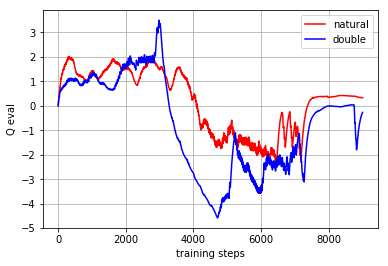

In [3]:
import matplotlib.pyplot as plt
plt.plot(np.array(q_natural), c='r', label='natural')
plt.plot(np.array(q_double), c='b', label='double')
plt.legend(loc='best')
plt.ylabel('Q eval')
plt.xlabel('training steps')
plt.grid()
plt.show()

In [13]:
# 程序仿真部分

import numpy as np
import pandas as pd
from numba import jit

class Area():
    def __init__(self, n, a_id):
        self.a_id = a_id
        self.normal_bike = n
        self.broken_bike = 0

    def move(self):
        self.normal_bike -= 1
        self.broken_bike += 1


def binaryInsert(target, events):
    for event in events:
        if event >= target[-1]:
            target.append(event)
        else:
            l, mid, r = 0, int(len(target) / 2), len(target) - 1
            while 1:
                if r - l == 1:
                    target.insert(r, event)
                    break
                else:
                    if event > target[mid]:
                        l = mid
                        mid = int((r + l) / 2)
                    else:
                        r = mid
                        mid = int((r + l) / 2)


def simulate(N, R, A, Q, P, t_limit):
    '''
    N: initial number of bikes in the network
    R: rates of arriving and departing for each node
    A: number of Areas
    Q: matrix of tansitition probability
    P: policy of dealing with broken bikes

    T: system clock
    scheduler: stack of upcoming events,[t, event_type, area], 1 for customer arrival, 2 for bike arrival
    
    stat: record of system state parameters
    loss: record of customer loss
    '''

    # initiate
    T = 0
    #stat, S = pd.DataFrame(columns=['type', 'place', 't']), 0
    loss, L = pd.DataFrame(columns=['place', 't']), 0
    broken, B = pd.DataFrame(columns=['place', 'ng', 'nb', 't']), 0

    # initiation of instances of Area and scheduler
    scheduler = []
    a = []
    for i in range(A):
        a.append(Area(N / A, i))
        scheduler.append([np.random.exponential(1/R.loc[i].cus_arr), 1, a[i]])
    scheduler.sort()

    # system running
    while T < t_limit:
        
        T = scheduler[0][0]
        if scheduler[0][1] == 1:
            #stat.loc[S], S = [scheduler[0][1], scheduler[0][2].a_id, T], S+1
            if scheduler[0][2].normal_bike == 0:
                # this is a loss
                loss.loc[L], L = [scheduler[0][2].a_id, T], L+1
                event = [T + np.random.exponential(1/R.loc[scheduler[0][2].a_id].cus_arr), 1, scheduler[0][2]]
                binaryInsert(scheduler, [event])
            else:
                target = np.random.choice(np.arange(A+1), 1, p=Q[scheduler[0][2].a_id])
                if target == A:
                    broken.loc[B], B = [scheduler[0][2].a_id, scheduler[0][2].normal_bike, scheduler[0][2].broken_bike, T], B+1
                    scheduler[0][2].move()
                    continue
                else:
                    scheduler[0][2].normal_bike -= 1
                    event1 = [T + np.random.exponential(1/R.loc[scheduler[0][2].a_id].ride), 2, a[target[0]]]
                    event2 = [T + np.random.exponential(1/R.loc[scheduler[0][2].a_id].cus_arr), 1, scheduler[0][2]]
                    binaryInsert(scheduler, [event1, event2])
        else:
            #stat.loc[S], S = [scheduler[0][1], scheduler[0][2].a_id, T], S+1
            scheduler[0][2].normal_bike += 1
        scheduler.pop(0)
        
    #return stat
    #return loss, broken
    return loss.shape[0]

if __name__ == '__main__':
    np.random.seed(1)
    N = 360
    A = 9
    R = pd.DataFrame({'cus_arr': [5] * A, 'ride': [10] * A}, index=range(A))
    Q = [np.random.rand(A+1) for i in range(A)]
    Q = [q / sum(q) for q in Q]
    #Q = [[0,0.9,0.1], [0.9,0,0.1]]
    P = 0
    time_limit = 60

    %time print(simulate(N, R, A, Q, P, time_limit))
    #result = simulate(N, R, A, Q, P, time_limit)



429
Wall time: 3.14 s


In [9]:
result[1]

,place,ng,nb,t
0,0.0,40.0,0.0,0.024376
1,4.0,40.0,0.0,0.104896
2,5.0,40.0,0.0,0.288923
3,1.0,47.0,0.0,0.597114
4,2.0,36.0,0.0,0.750627
5,6.0,43.0,0.0,0.836530
6,5.0,39.0,1.0,0.938654
7,2.0,33.0,1.0,0.964442
8,0.0,43.0,1.0,1.195615
9,2.0,32.0,2.0,1.284938
